# **Deep RL for Quantum Circuit Optimization**

This project implements a Deep Q-Network (DQN) agent, specifically a Deep Q-Network (DQN), to produce optimal quantum circuits. The goal is to automate the discovery of the most efficient (shortest gate-depth) quantum circuit that transforms an initial state into a target quantum state. This problem is relevant in the NISQ era, where minimizing circuit depth is directly linked to reducing error from noise and decoherence, and a higher execution fidelity.

In this notebook, we aim to synthesize a quantum circuit that generates a Greenberger-Horne-Zeilinger (GHZ) state, a fundamental entangled state in quantum computing.

**Table of Contents**

0. [Setup](#setup)

1. [Quantum Ennvironment](#quantum-environment)

    * [Target State](#target-state)
    * [Markov Decision Process](#markov-decision-process)
    * [Transition Dynamics](#transition-dynamics)

2. [Deep Q-Network Agent](#deep-q-network-agent)

    * [Q-Network Architecture](#q-network-architecture)
    * [Experience Memory](#experience-memory)
    * [Agent Design](#agent-design)

3. [Learning](#learning)

    * [Hyperparameter Definition](#hyperparameter-definition)
    * [Training Loop](#training-loop)

4. [Evaluation](#evaluation)

## **Setup**

To get started we import packages and libraries. We use [Qiskit](https://www.ibm.com/quantum/qiskit) for all quantum simulation, instead of real quantum hardware.

In [1]:
import random
import os
import time
import warnings
from pathlib import Path
from collections import deque, namedtuple

import numpy as np
import seaborn as sns
import pylatexenc
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, state_fidelity, Pauli, Operator

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

warnings.filterwarnings("ignore")

In [2]:
ROOT_DIR = str(Path.cwd().parents[0])

MODEL_DIR = os.path.join(ROOT_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

VECTOR_MODEL_DIR = f'{MODEL_DIR}/ghz_model'
os.makedirs(VECTOR_MODEL_DIR, exist_ok=True)

BEST_GHZ_PATH = f'{VECTOR_MODEL_DIR}/ghz_agent_best.pth'
INITIAL_GHZ_PATH = f'{VECTOR_MODEL_DIR}/ghz_agent_initial.pth'
HISTORY_GHZ_PATH = f'{VECTOR_MODEL_DIR}/ghz_train_history.pth'

print(f'root: {ROOT_DIR}')
print(f'model: {MODEL_DIR}')
print(f'vector model: {VECTOR_MODEL_DIR}')

root: /Users/sepehrakbari/Projects/rl-qcircuitry
model: /Users/sepehrakbari/Projects/rl-qcircuitry/model
vector model: /Users/sepehrakbari/Projects/rl-qcircuitry/model/ghz_model


No matter what target state we choose, the process of training the DQN agent remains the same, however, the complexity of the target state will affect the training time and the quality of the learned policy. For this educational project, we will first focus on a relatively simple target state, the [Greenberger–Horne–Zeilinger (GHZ)](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state) state with 3 qubits, which is defined as:

$$
|\text{GHZ}_3⟩ = \frac{1}{\sqrt{2}} (|000⟩ + |111⟩)
$$

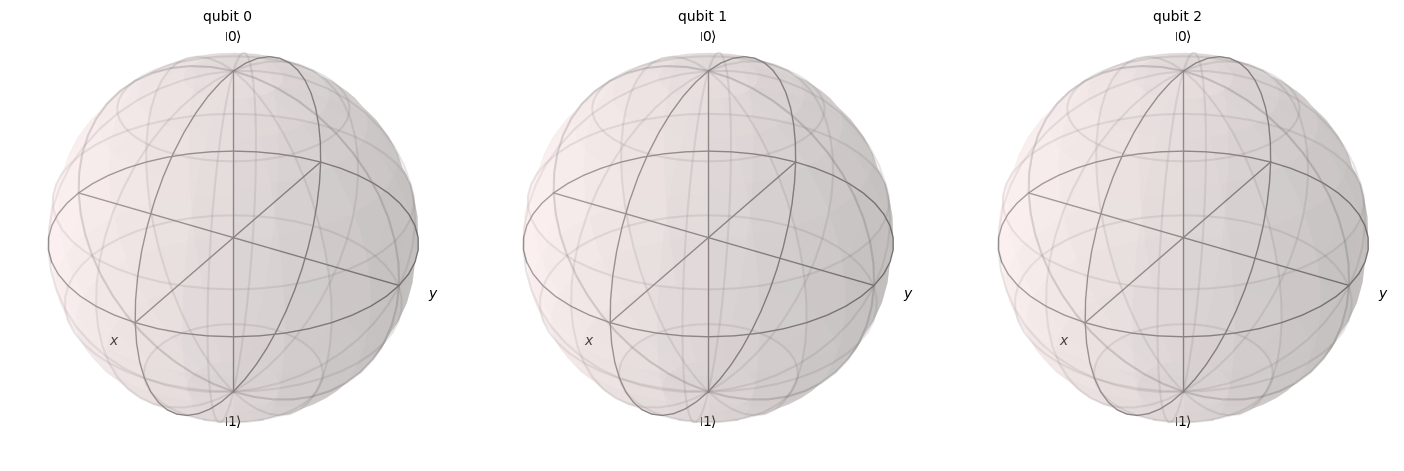

In [3]:
N_QUBITS = 3

TARGET_STATE_VECTOR = Statevector(
    [1/np.sqrt(2), 0, 0, 0, 0, 0, 0, 1/np.sqrt(2)]
) 

TARGET_STATE_VECTOR.draw('bloch')

Next, we define the action space for the RL agent. There are many possible quantum gates, but we'll limit ourselves to a small gate set that is universal for quantum computation. This includes single-qubit gates like Hadamard ($H$), Pauli-X ($X$) and a two-qubit CNOT ($CX$) gate. We also include rotation gates around the X and Z axes ($RX$ and $RZ$) to allow for more flexibility in state manipulation. 

In [4]:
GATE_SET = [
    ('h', 1),
    ('rx', 1),
    ('rz', 1),
    ('x', 1),
    ('cx', 2)
]

print(f"Number of gates: {len(GATE_SET)}")

Number of gates: 5


Based on these gates, we can define the action space for our RL agent. We'll save these as a list of possible actions in the format of `(gate_name, target_qubit, control_qubit)` for two-qubit gates, and `(gate_name, target_qubit)` for single-qubit gates, which is compatible with Qiskit's gate application methods.

In [5]:
POSSIBLE_ACTIONS = []

for name, num_q in GATE_SET:
    if num_q == 1:
        for q in range(N_QUBITS):
            POSSIBLE_ACTIONS.append((name, q, None))
    elif num_q == 2:
        for control in range(N_QUBITS):
            for target in range(N_QUBITS):
                if control != target:
                    POSSIBLE_ACTIONS.append((name, target, control))

N_ACTIONS = len(POSSIBLE_ACTIONS)

print(f"Number of Actions: {N_ACTIONS}")
print(f"Sample Actions: {POSSIBLE_ACTIONS[11:13]}")

Number of Actions: 18
Sample Actions: [('x', 2, None), ('cx', 1, 0)]


## **Quantum Environment**

In this section we will implement the quantum environment as a Markov Decision Process (MDP) that the DQN agent will interact with to learn.

### Target State

Lets start our implementation by simulating the target state. A well known optimal circuit for generating the GHZ state is to apply a Hadamard gate on the first qubit followed by two CNOT gates from the first qubit. We expect the fidelity between the state by the reference circuit and the target state to be 1.0 since they are identical.

Circuit Depth: 3
Vector Dimension: 8
Fidelity: 1.00


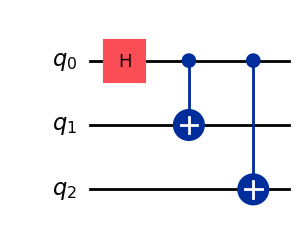

In [6]:
qc_ghz = QuantumCircuit(N_QUBITS)
qc_ghz.h(0)
qc_ghz.cx(0, 1)
qc_ghz.cx(0, 2)

qc_ghz_state = Statevector(qc_ghz)
fidelity = state_fidelity(TARGET_STATE_VECTOR, qc_ghz_state)

print(f"Circuit Depth: {qc_ghz.depth()}")
print(f"Vector Dimension: {TARGET_STATE_VECTOR.dim}")
print(f"Fidelity: {fidelity:.2f}")

qc_ghz.draw('mpl')

This verifies that our defined target state vector matches the expected GHZ state. The circuit shown above is the optimal circuit for generating the GHZ state with 3 qubits, and the fidelity check confirms that our target state vector is correctly represented.

### Markov Decision Process

In this section, we define the Markov Decision Process (MDP) for our quantum environment. I will walk through the components of the MDP, and then put it all together in its own class for easy integration with the DQN agent.

First, we initialize the environment with the number of qubits, the target state vector, the possible actions (quantum gates), and a maximum number of gates (circuit depth) to prevent infinite episodes and terminate. Instead of using an exponentially large state vector to represent the quantum state, we use a more compact representation based on the expectation values of the Pauli operators ($X$, $Y$, $Z$) for each qubit, which will be a linearly sized state representation (3 values per qubit). This summarizes the quantum state, and will ultimately be the input to our neural network. So a list of single-qubit Pauli observables is created for each qubit in the system, this list is generated by the next method defined. We also initialize a variable to keep track of the last fidelity achieved, which will be useful for reward calculation. Finally, the reset method initializes the environment state to the all-zero state and resets the step counter.

In [7]:
def __init__(self, n_qubits, target_state, possible_actions, max_gates=20):
    '''
    Initializes the Quantum Circuit MDP environment.
    '''
    self.N_QUBITS = n_qubits
    self.TARGET_STATE_VECTOR = target_state
    self.POSSIBLE_ACTIONS = possible_actions
    self.N_ACTIONS = len(possible_actions)
    self.MAX_GATES = max_gates
    
    self.STATE_DIM = n_qubits * 3 
    self.PAULI_OBSERVABLES = self._get_pauli_observables()
    
    self.last_fidelity = 0.0
    self.reset()

The `_get_pauli_observables()` creates a list of tensor products of the Pauli operators ($X$, $Y$, and $Z$) along with the identity operator ($I$) for each qubit in the system. In general, for a $N$-qubit system, there are $3N$ such single-qubit Pauli observables. For the Pauli-$X$ for example, the operator acting on the $i^{th}$ qubit is represented as:

$$
X_i = I \otimes ... \otimes X \otimes ... \otimes I
$$

This is the set of operators that will be measured to form the agent's observation. Note, Qiskit uses different ordering here, so we reverse the order of qubits before passing them to `Pauli`.

In [8]:
def _get_pauli_observables(self):
    '''
    Generates the list of single-qubit Pauli observables for state representation.
    '''
    operators = []
    pauli_bases = ['X', 'Y', 'Z']
    
    for i in range(self.N_QUBITS):
        for basis in pauli_bases:
            pauli_string = ['I'] * self.N_QUBITS
            pauli_string[i] = basis
            pauli_string_qiskit = "".join(pauli_string[::-1])
            operators.append(Pauli(pauli_string_qiskit))
    return operators

Next, the `reset()` method will be applied at the beginning of each episode to initialize the environment state to the all-zero state and reset the step counter. We just initialize a new quantum circuit with all qubits in the $|0\rangle$ state, reset the gate count and maximum fidelity achieved so far. We then compute the initial state vector from this circuit and return its state representation for the agent, using the next method defined.

In [9]:
def reset(self):
    '''
    Resets the environment to the initial state.
    '''
    self.current_circuit = QuantumCircuit(self.N_QUBITS)
    
    self.gate_count = 0
    self.max_fidelity = 0.0
    self.last_fidelity = 0.0
    
    initial_state_vector = Statevector(self.current_circuit)
    return self._get_state_representation(initial_state_vector)

The `_get_state_representation()` is the main method that converts the quantum state into a feature vector. The main complexity as mentioned before is that the quantum state vector for $N$ qubits has $2^N$ complex values, which will quickly become too large for our RL agent. This method will use the already-defined list of Pauli operators to compute the expectation values for each operator with respect to the current quantum state. The expectation value of an operator $O$ for a current state $|\psi⟩$ is given by:

$$
\langle O \rangle = \langle \psi | O | \psi \rangle = \text{Tr}(O \rho)
$$

Where $\text{Tr}$ is the trace operation and $\rho = |\psi⟩⟨\psi|$ is the density matrix of the state. But of course we will just Qiskit's built-in methods for all this since this is not a quantum computing notebook.

There are $3N$ such expectation values for $N$ qubits, which gives us a feature vector of size $3N$. We will also convert these expectation values to real numbers since they can be complex sometimes due to a tiny numerical error (I believe due to floating point error). This method then converts this list of expectation values into a PyTorch tensor, which will be the input to our DQN agent.

In [10]:
def _get_state_representation(self, state_vector):
    '''
    Generates the state representation based on expectation values of Pauli observables.
    '''
    state_features = []
    for pauli_op in self.PAULI_OBSERVABLES:
        exp_val = state_vector.expectation_value(pauli_op)
        state_features.append(np.real(exp_val))
        
    return torch.tensor(state_features, dtype=torch.float32)

### Transition Dynamics

The last block of our MDP is the `step()` method, which applies the selected action (quantum gate) to the current quantum circuit, updates the state representation, computes the reward based on fidelity, and checks if the episode is done (either by reaching maximum fidelity or exceeding maximum gates). I will walk through each part of this method by marking each step with comments.

1. First we execute the selected action on the current quantum circuit. For our rotation gates we apply a fixed rotation angle of $\pi/2$ radians for simplicity. After applying the gate, we increment the gate count to keep track of the depth of the circuit.

2. After applying the gate, the environment calculates the new quantum state and evaluates its quality. We turn it into a state vector, compute the fidelity with respect to the target state vector, and update the maximum fidelity achieved so far in this episode. Finally we get the new state representation for the agent using the previously defined method.

3. Here we define the reward structure and termination conditions for the episode. The reward starts with a small negative penalty (-0.01) for each gate applied, to encourage shorter circuits (less depth). Then, if the fidelity computed exceeds our threshold we give a large positive reward (+10), and mark the episode as done. If the maximum number of gates is reached without achieving the target fidelity, we also terminate the episode, but without a success reward. To further encourage the agent to improve fidelity at each step, we add a reward proportional to the increase in fidelity since the last step, scaled by a weight factor (5.0). This helps guide the agent towards better states even if it hasn't reached the target fidelity yet, and encourages incremental improvements.

In [11]:
def step(self, action_index):
    '''
    Represents one step in the MDP environment, including action execution, fidelity computation, and reward determination.
    '''
    # 1. Executing the Action
    
    gate_name, target_q, control_q = self.POSSIBLE_ACTIONS[action_index]
    
    if control_q is None:
        if gate_name == 'h':
            self.current_circuit.h(target_q)
        elif gate_name == 'x':
            self.current_circuit.x(target_q)
        elif gate_name == 'rx':
            self.current_circuit.rx(np.pi/2, target_q) 
        elif gate_name == 'rz':
            self.current_circuit.rz(np.pi/2, target_q)
    else:
        if gate_name == 'cx':
            self.current_circuit.cx(control_q, target_q)
    
    self.gate_count += 1
    
    # 2. Fidelity Computation & State Update
    
    current_state_vector = Statevector(self.current_circuit)
    fidelity = state_fidelity(self.TARGET_STATE_VECTOR, current_state_vector)
    
    self.max_fidelity = max(self.max_fidelity, fidelity)
    
    next_state = self._get_state_representation(current_state_vector)
    
    # 3. Determine Reward and Termination
    
    REWARD_GATE_PENALTY = -0.01
    REWARD_SUCCESS = 10.0
    FIDELITY_THRESHOLD = 0.999
    REWARD_FIDELITY_WEIGHT = 5.0
    
    done = False
    reward = REWARD_GATE_PENALTY
    
    if fidelity >= FIDELITY_THRESHOLD:
        reward += REWARD_SUCCESS 
        done = True
    elif self.gate_count >= self.MAX_GATES:
        done = True
    
    reward += REWARD_FIDELITY_WEIGHT * (fidelity - self.last_fidelity)
    self.last_fidelity = fidelity

    return next_state, reward, done

Combining all these components, we have a complete MDP definition for our quantum environment, which can now be used to train the DQN agent to discover optimal quantum circuits (hopefully!).

In [12]:
class QuantumCircuitEnv:
    def __init__(self, n_qubits, target_state, possible_actions, max_gates=20, REWARD_GATE_PENALTY=-0.1, REWARD_SUCCESS=10.0, FIDELITY_THRESHOLD=0.999, REWARD_FIDELITY_WEIGHT=5.0):
        '''
        Initializes the Quantum Circuit MDP environment.
        '''
        self.N_QUBITS = n_qubits
        self.TARGET_STATE_VECTOR = target_state
        self.POSSIBLE_ACTIONS = possible_actions
        self.N_ACTIONS = len(possible_actions)
        self.MAX_GATES = max_gates
        
        self.STATE_DIM = n_qubits * 3 
        self.PAULI_OBSERVABLES = self._get_pauli_observables()
        
        self.last_fidelity = 0.0
        
        self.REWARD_GATE_PENALTY = REWARD_GATE_PENALTY
        self.REWARD_SUCCESS = REWARD_SUCCESS
        self.FIDELITY_THRESHOLD = FIDELITY_THRESHOLD
        self.REWARD_FIDELITY_WEIGHT = REWARD_FIDELITY_WEIGHT
        
        self.reset()
    
    def _get_pauli_observables(self):
        '''
        Generates the list of single-qubit Pauli observables for state representation.
        '''
        operators = []
        pauli_bases = ['X', 'Y', 'Z']
        
        for i in range(self.N_QUBITS):
            for basis in pauli_bases:
                pauli_string = ['I'] * self.N_QUBITS
                pauli_string[i] = basis
                pauli_string_qiskit = "".join(pauli_string[::-1])
                operators.append(Pauli(pauli_string_qiskit))
        return operators
    
    def reset(self):
        '''
        Resets the environment to the initial state.
        '''
        self.current_circuit = QuantumCircuit(self.N_QUBITS)
        
        self.gate_count = 0
        self.max_fidelity = 0.0
        self.last_fidelity = 0.0
        
        initial_state_vector = Statevector(self.current_circuit)
        return self._get_state_representation(initial_state_vector)
    
    def _get_state_representation(self, state_vector):
        '''
        Generates the state representation based on expectation values of Pauli observables.
        '''
        state_features = []
        for pauli_op in self.PAULI_OBSERVABLES:
            exp_val = state_vector.expectation_value(pauli_op)
            state_features.append(np.real(exp_val))
            
        return torch.tensor(state_features, dtype=torch.float32)
    

    def step(self, action_index):
        '''
        Represents one step in the MDP environment, including action execution, fidelity computation, and reward determination.
        '''
        gate_name, target_q, control_q = self.POSSIBLE_ACTIONS[action_index]
        
        if control_q is None:
            if gate_name == 'h':
                self.current_circuit.h(target_q)
            elif gate_name == 'x':
                self.current_circuit.x(target_q)
            elif gate_name == 'rx':
                self.current_circuit.rx(np.pi/2, target_q) 
            elif gate_name == 'rz':
                self.current_circuit.rz(np.pi/2, target_q)
        else:
            if gate_name == 'cx':
                self.current_circuit.cx(control_q, target_q)
        
        self.gate_count += 1
                
        current_state_vector = Statevector(self.current_circuit)
        fidelity = state_fidelity(self.TARGET_STATE_VECTOR, current_state_vector)
        
        self.max_fidelity = max(self.max_fidelity, fidelity)
        
        next_state = self._get_state_representation(current_state_vector)
        
        done = False
        reward = self.REWARD_GATE_PENALTY
        
        if fidelity >= self.FIDELITY_THRESHOLD:
            reward += self.REWARD_SUCCESS 
            done = True
        elif self.gate_count >= self.MAX_GATES:
            done = True
        
        reward += self.REWARD_FIDELITY_WEIGHT * (fidelity - self.last_fidelity)
        self.last_fidelity = fidelity

        return next_state, reward, done

## **Deep Q-Network Agent**

In this section, we will build a DQN algorithm through implementing a Deep Q-Neural Network (DQN), an experience replay memory, and the greedy policy for action selection.

### Q-Network Architecture

The Q-Network is a standard feedforward neural network that takes the state vector (Pauli expectation values) as input and outputs a Q-value for every possible action. Recall that our target state is not very complex, so we can use a relatively small network architecture. The network consists of two hidden layers with ReLU activations, which should be sufficient for learning the Q-function for this task. The final output layer has a number of neurons equal to the number of possible actions (`action_dim`), each value in this output vector represents the estimated Q-value for taking the corresponding action in the input state.

In [13]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        '''
        Initializes the Deep Q-Network structure.
        '''
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
         
        self.relu = nn.ReLU()

    def forward(self, state):
        '''
        Forward pass to compute Q-values for all actions in a given state.
        '''
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

### Experience Memory

A bold problem in RL methods like DQN is the correlation between sequential experiences, which can lead to inefficient learning and divergence. To address this, we implement a mechanism that would store past "experiences" in a buffer, and randomly sample from this buffer to train the Q-Network. This breaks the correlation between consecutive experiences and leads to more stable learning.

We begin with defining a tuple to represent a single transition (or experience), which includes the current state, action taken, reward received, next state, and whether the episode has terminated. The buffer is initialized with a capacity, which defines its maximum size. When the capacity is exceeded, deque automatically discards the oldest experience, ensuring the memory contains a balance of recent experiences and diverse past ones. The `push()` method is called after every step the agent takes in the environment which takes the five transition elements ($s$, $a$, $r$, $s'$, $\text{done}$) and converts them into an `Experience` tuple, which is then appended to the internal memory deque. The last method just returns the current size of the memory buffer.

The `sample()` method selects a random subset of experiences from anywhere within the buffer. This randomization breaks the temporal correlation of sequential experiences, meaning the network isn't repeatedly training on a single, short, correlated sequence of events, which would lead to unstable updates. The line with assignment to `batch` unpacks the samples, if for example we have a batch of 32 experiences, it gets transposed into 5 separate tuples of size 32, grouping all states, actions, etc. together. Then the stacking operation combines the list of individual state tensors into a single batch tensor. Finally we add a dimension to the action, state, and done tensors to prepare them for matrix operations with the neural network outputs.

In [14]:
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        '''
        Initializes the Replay Buffer with a fixed capacity.
        '''
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Saves a transition (s, a, r, s', done) to the buffer.
        '''
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        '''
        Randomly samples a batch of transitions for learning.
        '''
        if len(self.memory) < batch_size:
            return None

        transitions = random.sample(self.memory, batch_size)
        
        batch = Experience(*zip(*transitions))
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
        next_state_batch = torch.stack(batch.next_state)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.memory)

### Agent Design

We now have all the components needed to build our DQN agent. The agent will use the Q-Network to estimate Q-values, select actions using an epsilon-greedy policy, store experiences in the replay buffer, and update the Q-Network using sampled experiences. I will walk though each part of the agent, and then put it all together in its own class for easy use.

In the construcutor, we set the discount factor ($\gamma$), learning rate ($\alpha$), and replay buffer capacity. We also set the device for PyTorch tensors (in this notebook we will use MPS). We will initialize two Q-Networks:

- Policy Network: the network that the agent actively trains. It takes a state (Pauli expectation values) and outputs the predicted Q-value for every possible action.

- Target Network: an identical copy of the policy network, but its weights are frozen (or updated slowly). The purpose of the target network is to calculate the target Q-values. Using a separate, stable network prevents the Q-value from chasing a moving target (itself), which improves training stability.

We can then put the target network in evaluation mode since its never trained, select the Adam optimizer for our gradient updates, and initialize the memory buffer. Finally we initialize a step counter to keep track of how many actions the agent has taken, which will be useful for epsilon decay during action selection.

In [15]:
def __init__(self, state_dim, action_dim, device, gamma, lr, capacity):
    '''
    Initializes the DQN Agent with policy and target networks, optimizer, and replay buffer.
    '''
    self.DEVICE = device
    self.GAMMA = gamma
    
    self.policy_net = QNetwork(state_dim, action_dim).to(device)
    
    self.target_net = QNetwork(state_dim, action_dim).to(device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()

    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
    self.memory = ReplayBuffer(capacity)
    
    self.steps_done = 0

Next we will implement the epsilon-greedy action selection strategy to balance exploration and exploitation. Epsilon ($\epsilon$) is a parameter that defines a probability of choosing a random action (exploration) versus choosing the best-known action according to the Q-Network (exploitation). A higher epsilon encourages more exploration, while a lower epsilon favors exploitation of learned knowledge. In this implementation, we generate a random number between 0 and 1, if this number is less than epsilon, we select a random action from the action space. 

Otherwise, we feed the current state into the policy network to predict the Q-values for all possible actions, and select the action with the highest Q-value using `argmax(1)` to get the index of the maximum value along the action dimension. The `torch.no_grad()` context is used to disable gradient calculations during this inference step, which improves efficiency since we don't need gradients when just selecting actions.

In [16]:
def select_action(self, state, epsilon):
    '''
    Selects an action using the epsilon-greedy strategy.
    '''
    if random.random() < epsilon:
        return random.randrange(self.policy_net.fc3.out_features)
    else:
        with torch.no_grad():
            return self.policy_net(state).argmax(1).item()

This method performs the core update of the DQN algorithm using the Bellman Equation to minimize the Temporal Difference (TD) error. I'll break this down into parts with comments:

1. First we sample a batch of experiences from the replay buffer. If there are not enough experiences yet, we simply return without updating. We pass the state batch through the policy network to predict the Q-values for all actions in the current state $s_t$. The `gather` operation selects only the Q-value corresponding to the specific action $a_t$ that was actually taken in that experience. This is the value we want to update.

2. The target Q-value is derived from the Bellman Equation

$$
y_t = r_t + \gamma \max_{a'} Q_{\text{target}}(s_{t+1}, a')
$$

- Next state value:

    The target network predicts the Q-values for the next state $s_{t+1}$. We take the max value over all possible next actions $a'$ to find the optimal future value ($\max_{a'} Q_{\text{target}}(s_{t+1}, a')$). 

- Terminal state:

    If the episode ended (`done_batch` is 1), the Q-value of the next state must be 0. Multiplying by ($1 - \text{done}$) handles this, correctly setting the future value to 0 for terminal states.

- TD target:

    Lastly, we compute $y_t$.

3. We use the [Huber loss function](https://en.wikipedia.org/wiki/Huber_loss) to measure the difference (TD error) between the current Q-value prediction ($Q(s_t, a_t)$) and the stable TD target ($y_t$). We choose Huber loss because it is less sensitive to outliers than mean squared error, which can help stabilize training. We then perform the standard backpropagation steps to compute gradients and update the policy network weights using the Adam optimizer. Gradient clipping is applied (to a maximum value) to prevent excessively large updates that could destabilize training.

In [17]:
def learn(self, batch_size):
    '''
    Performs one optimization step on the policy network using a batch from replay memory.
    '''
    # 1. Sampling a Batch of Experiences
    
    batch = self.memory.sample(batch_size)
    if batch is None:
        return 
    
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
    
    state_action_values = self.policy_net(state_batch).gather(1, action_batch)

    # 2. Computing the Target Q-Value
    
    next_state_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
    
    next_state_values = next_state_values * (1 - done_batch)
    
    expected_state_action_values = reward_batch + (self.GAMMA * next_state_values)

    # 3. Loss computation and backpropagation
    
    loss = F.huber_loss(state_action_values, expected_state_action_values)

    self.optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1.0)
    self.optimizer.step()
    
    return loss.item()

Combining all these components, we have a complete DQN agent that can interact with the quantum environment, learn from experiences, and improve its policy for discovering optimal quantum circuits.

In [18]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, device, gamma, lr, capacity):
        '''
        Initializes the DQN Agent with policy and target networks, optimizer, and replay buffer.
        '''
        self.DEVICE = device
        self.GAMMA = gamma
        
        self.policy_net = QNetwork(state_dim, action_dim).to(device)
        
        self.target_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(capacity)
        
        self.steps_done = 0
    
    def select_action(self, state, epsilon):
        '''
        Selects an action using the epsilon-greedy strategy.
        '''
        if random.random() < epsilon:
            return random.randrange(self.policy_net.fc3.out_features)
        else:
            with torch.no_grad():
                return self.policy_net(state).argmax(1).item()

    def learn(self, batch_size):
        '''
        Performs one optimization step on the policy network using a batch from replay memory.
        '''
        batch = self.memory.sample(batch_size)
        if batch is None:
            return 
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
        next_state_values = next_state_values * (1 - done_batch)
        
        expected_state_action_values = reward_batch + (self.GAMMA * next_state_values)

        loss = F.huber_loss(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()

## **Learning**

In this section we will train the DQN agent in the quantum environment to learn optimal quantum circuits for generating the target GHZ state.

### Hyperparameter Definition

We define the key constants that govern the RL training process. These have been chosen initially based on common practices, but have been somewhat tunded through experimentation.

First, we will set the parameters for the DQN agent. The discount factor ($\gamma$) determines how much future rewards are valued compared to immediate rewards. A value close to 1 means future rewards are nearly as important as immediate ones, which encourages the agent to consider long-term benefits. The learning rate controls how quickly the neural network updates its weights during training; a smaller value leads to more gradual updates. The batch size defines how many experiences are sampled from the replay buffer for each training step, affecting the stability and speed of learning. The target update frequency specifies how often the target network is updated with the policy network's weights, which helps stabilize training. Finally, the replay capacity sets the maximum size of the experience replay buffer, balancing memory usage and diversity of experiences.

In [19]:
GAMMA = 0.99 # Discount factor for future rewards
LEARNING_RATE = 1e-4 # Learning rate for the Adam
BATCH_SIZE = 64 # Number of transitions sampled from the replay buffer
TARGET_UPDATE = 100 # Frequency (in steps) to update the target Q-network
REPLAY_CAPACITY = 10000 # Max size of the replay memory

The parameters for the epsilon-greedy action selection strategy are defined next. For more robust exploration, I will not set a fixed epsilon value, rather will start the training with full exploration ($\epsilon = 1.0$) and gradually decay it to a small value ($\epsilon = 0.05$) over a large number of steps (`EPS_DECAY` = 50000). This allows the agent to explore the environment thoroughly in the beginning, and then slowly shift towards exploiting learned knowledge as training progresses. Finally, we set the total number of training episodes to 20000, which should provide sufficient experience for the agent to learn effective policies.

In [20]:
EPS_START = 1.0 # Starting value of epsilon (100% exploration)
EPS_END = 0.1 # Final minimum value of epsilon
EPS_DECAY = 50000 # Number of steps over which epsilon decays linearly
N_EPISODES = 20000 # Total number of training episodes

We also need to define our reward parameters, which I have already walked through in the [Transition Dynamics](#transition-dynamics) section.

In [21]:
REWARD_GATE_PENALTY = -0.1 # Penalty for each gate applied
REWARD_SUCCESS = 10.0 # Reward for successfully reaching the target state
FIDELITY_THRESHOLD = 0.999 # Fidelity threshold to consider the target state reached
REWARD_FIDELITY_WEIGHT = 5.0 # Weight for the fidelity component of the reward

Finally, we set the device to cuda if available and CPU otherwise. Note that we cannot use MPS here since our sampling strategy uses some storage that needs to be defined on MPS, and this causes complexities. For this size of problem, CPU should be sufficient.

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


We now set our environment and agent, using the previously defined classes and the hyperparameters.

In [23]:
env = QuantumCircuitEnv(
    n_qubits=N_QUBITS, 
    target_state=TARGET_STATE_VECTOR, 
    possible_actions=POSSIBLE_ACTIONS,
    REWARD_GATE_PENALTY=REWARD_GATE_PENALTY,
    REWARD_SUCCESS=REWARD_SUCCESS,
    FIDELITY_THRESHOLD=FIDELITY_THRESHOLD,
    REWARD_FIDELITY_WEIGHT=REWARD_FIDELITY_WEIGHT,
    max_gates=20)

STATE_DIM = env.STATE_DIM
N_ACTIONS = env.N_ACTIONS

agent = DQNAgent(
    state_dim=STATE_DIM, 
    action_dim=N_ACTIONS, 
    device=DEVICE, 
    gamma=GAMMA, 
    lr=LEARNING_RATE, 
    capacity=REPLAY_CAPACITY)

### Training Loop

With all components in place, we now implement a training loop. The core logic involves a double-loop structure; the outer loop tracks episodes, and the inner loop manages steps within a single episode. To ensure the agent learns effectively and stably, the loop incorporates some scheduling mechanisms, including epsilon decay for balanced exploration and exploitation and periodic Target Network updates for training stability as previosly said, along with an Exponential Learning Rate decay to refine convergence. Additionally, it will also feature an Early Stopping mechanism, using a moving average reward over 100 episodes to prevent unnecessary training once the performance plateaus or a success threshold is met. I will explain the implementation in more detail.

In [24]:
SCHEDULER_GAMMA = 0.99995 # Exponential decay rate for the Learning Rate
PATIENCE = 50 # Number of 100-episode windows to wait for reward improvement
MIN_AVG_REWARD = 14.0 # Minimum average reward threshold to consider successful

LR_SCHEDULER = optim.lr_scheduler.ExponentialLR(agent.optimizer, gamma=SCHEDULER_GAMMA)

1. Outer loop:

    - The environment is reset to the initial state, and per-episode metrics are reset.
    - At the end of every episode, `LR_SCHEDULER.step()` is called to slightly decrease the optimizer's learning rate, promoting steady convergence.
    - Episode metrics (total reward, final circuit depth, max fidelity) are recorded. The total reward is added to the 100-episode reward window.

2. Inner loop:

    - This loop represents the agent's interaction with the environment for a single episode until termination (`done` is True).
    - The epsilon value is calculated based on `agent.steps_done` and the decay constants, ensuring a continuous transition from exploration to exploitation.
    - The agent selects an action using the greedy strategy, and the environment executes the gate (`step()`).
    - The resulting transition is stored in the replay buffer.
    - If the replay buffer has enough samples, the agent performs a training step, updating the Policy Network using the TD-error from the sampled batch.
    - Periodically (every `TARGET_UPDATE`), the weights of the stable Target Network are synchronized with the Policy Network to maintain training stability.

3. Early stopping:

    - If `avg_reward` improves, `best_avg_reward` is updated, and `patience_counter` is reset.
    - If `avg_reward` hits the `MIN_AVG_REWARD` threshold, the training loop breaks successfully.
    - If `avg_reward` fails to improve for the duration of `PATIENCE` windows, the training loop breaks early, concluding that the agent has plateaued.

In [25]:
def train_dqn(n_episodes, env, agent, initial_model_path, best_model_path, train_history_path):
    '''
    Trains the agent in the environment, returning rewards and final depths, and saving the best model.
    '''
    all_rewards = []
    final_depths = []
    reward_window = deque(maxlen=100)

    best_avg_reward = -np.inf
    patience_counter = 0 
        
    for episode in range(1, n_episodes + 1):
        
        if episode == 1 and not os.path.exists(initial_model_path):
            os.makedirs(os.path.dirname(initial_model_path), exist_ok=True)

            torch.save(agent.policy_net.state_dict(), initial_model_path)
                        
        state = env.reset().to(DEVICE)
        done = False
        total_reward = 0
        
        while not done:
            epsilon = max(EPS_END, EPS_START - (agent.steps_done / EPS_DECAY))
            
            action = agent.select_action(state.unsqueeze(0), epsilon)
            next_state_tensor, reward, done = env.step(action)
            next_state = next_state_tensor.to(DEVICE)
            
            total_reward += reward
            agent.steps_done += 1
            
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            
            if len(agent.memory) > BATCH_SIZE:
                agent.learn(BATCH_SIZE)
                
            if agent.steps_done % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())

        LR_SCHEDULER.step() 
        
        all_rewards.append(total_reward)
        final_depths.append(env.gate_count)
        reward_window.append(total_reward)
        
        if episode % 100 == 0:
            avg_reward = np.mean(reward_window)
            current_lr = agent.optimizer.param_groups[0]['lr']
            
            print(f"Episode {episode:6d}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:7.2f} | "
                  f"Max F: {env.max_fidelity:.4f} | "
                  f"Depth: {env.gate_count:3d} | "
                  f"LR: {current_lr:.2e} | "
                  f"Eps: {epsilon:.3f}")

            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                patience_counter = 0
                torch.save(agent.policy_net.state_dict(), best_model_path)
            else:
                patience_counter += 1
                
            if avg_reward >= MIN_AVG_REWARD or patience_counter >= PATIENCE:
                if avg_reward >= MIN_AVG_REWARD:
                    print(f"\nStopping early: target average reward ({MIN_AVG_REWARD}) reached.")
                elif patience_counter >= PATIENCE:
                    print(f"\nStopping: average reward has not improved for {PATIENCE*100} episodes.")
                break 
    
    history = {
        'rewards': all_rewards,
        'depths': final_depths
    }
    torch.save(history, train_history_path)
                            
    return all_rewards, final_depths

To avoid retraining in every run, we implement model saving and loading to only train the agent if no pre-trained model is found.

In [26]:
def load_agent(agent, model_path, device):
    """
    Checks for a saved model checkpoint and loads its state dict into the agent's policy net.
    """
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    if os.path.exists(model_path):
        try:
            agent.policy_net.load_state_dict(torch.load(model_path, map_location=device))
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
            
            agent.policy_net.eval()
            agent.target_net.eval()
            
            return True
        
        except Exception as e:
            print(f"Error loading model: {e}")
            return False
    else:
        return False

## **Evaluation**

We have implemented all the components needed to train a DQN agent to discover optimal quantum circuits for generating a target GHZ state.

The training loop orchestrates the interaction between the agent and the environment, allowing the agent to learn from its experiences over many episodes. To evaluate the performance, I initialize the agent and load the trained model weights (or train if its the first time). The training will give us the first state of the model, which is essentially random weights, and the best state of the model after training (based on average reward). We also obtain the rewards and depths history for later analysis.

In [27]:
best_is_loaded = load_agent(agent, BEST_GHZ_PATH, DEVICE)
initial_is_loaded = load_agent(agent, INITIAL_GHZ_PATH, DEVICE)
history_is_loaded = os.path.exists(HISTORY_GHZ_PATH)

if not best_is_loaded or not initial_is_loaded or not history_is_loaded:
    rewards, depths = train_dqn(N_EPISODES, env, agent, INITIAL_GHZ_PATH, BEST_GHZ_PATH, HISTORY_GHZ_PATH)
else:
    print("Training skipped.")

Training skipped.


In [35]:
history_data = torch.load(HISTORY_GHZ_PATH)
rewards = history_data['rewards']
depths = history_data['depths']

def plot_training(data, window_size=100, title=""):
    '''
    Plots the raw data and its moving average.
    '''
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, 'valid')
    
    plt.figure(figsize=(12, 5))
    plt.plot(smoothed_data, color='tab:red')
    plt.title(title)
    plt.xlabel("Episode")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

The plot below shows the rewards over time, smoothed with a moving average to visualize trends. We can see that the agent's performance improves over time, with rewards increasing as it learns better policies. We can clearly see that the reward converges, the peaks and valleys are an artifect of our epsilon-greedy exploration strategy, randomly taking suboptimal actions to explore the environment.

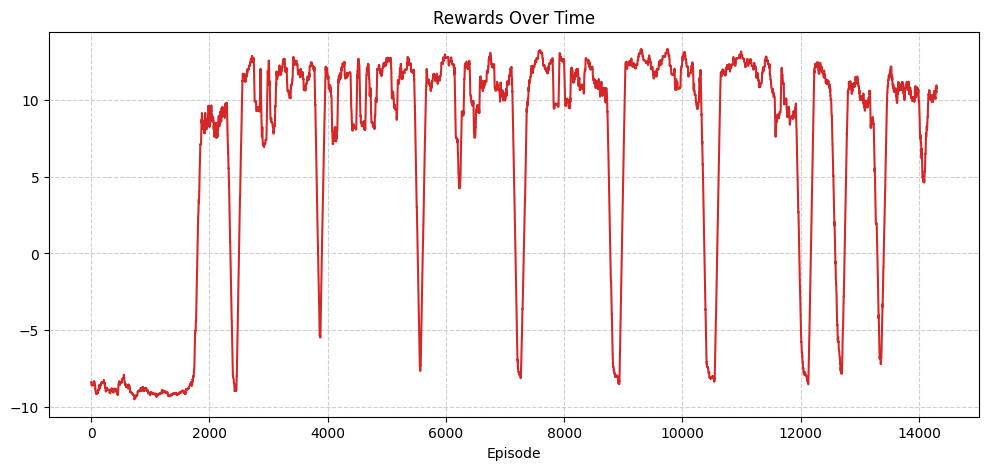

In [38]:
plot_training(rewards, window_size=100, title="Rewards Over Time")

The plot below shows the circuit depths over time, which looks very much similar to the rewards plot. This is expected since the reward structure penalizes circuit depth highly, so as the agent learns to maximize rewards, it also learns to minimize circuit depth.

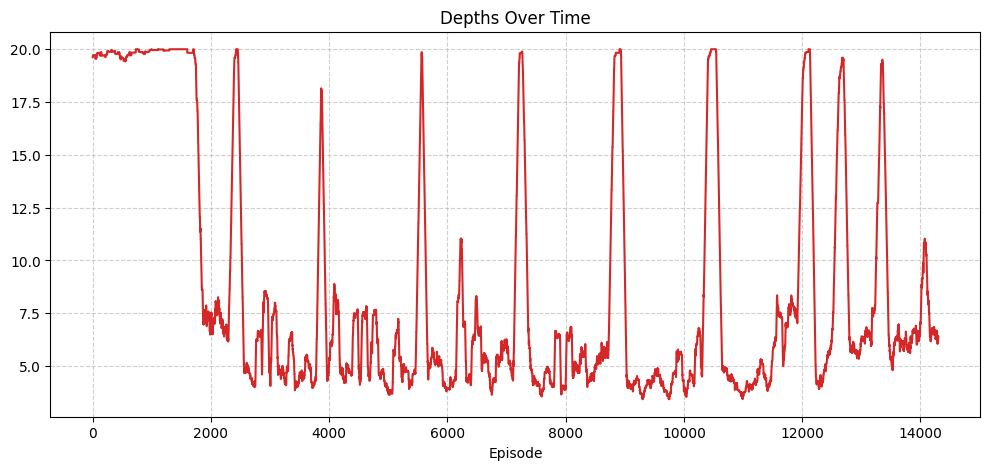

In [37]:
plot_training(depths, window_size=100, title="Depths Over Time")

In [31]:
def eval_policy(agent, env, model_path='untrained'):
    """
    Loads agent and runs a single greedy episode.
    """
    if model_path != 'untrained':
        try:
            agent.policy_net.load_state_dict(torch.load(model_path, map_location=DEVICE))
            agent.policy_net.eval()
        except FileNotFoundError:
            print(f"{model_path} not found.")
            return None, None, None 
               
    state = env.reset().to(DEVICE)
    final_circuit = env.current_circuit
    
    with torch.no_grad():
        done = False
        while not done:
            action_idx = agent.select_action(state.unsqueeze(0), epsilon=0.0) 
            
            next_state_tensor, _, done = env.step(action_idx)
            state = next_state_tensor.to(DEVICE)
    
    final_fidelity = state_fidelity(env.TARGET_STATE_VECTOR, Statevector(final_circuit))
    final_depth = final_circuit.depth()
    
    return final_circuit, final_depth, final_fidelity

To compare really evaluate our final performance and agent's learning, we'll look at the ground truth which is the optimal circuit for generating the GHZ state for comparison.

Ground truth depth: 3
Ground truth fidelity: 1.0000


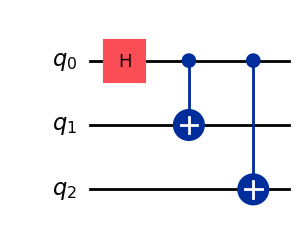

In [32]:
truth = QuantumCircuit(N_QUBITS)
truth.h(0)
truth.cx(0, 1)
truth.cx(0, 2)

fidelity_truth = state_fidelity(env.TARGET_STATE_VECTOR, Statevector(truth))

print(f'Ground truth depth: {truth.depth()}')
print(f'Ground truth fidelity: {fidelity_truth:.4f}')
truth.draw('mpl')

The initial circuit is made from random weights, in the start of training. This demonstrates a circuit that is very high in depth (20 is the max allowed) and very low in fidelity. This is expected since the agent has not learned anything yet.

Initial policy depth: 20
Initial policy fidelity: 0.2500


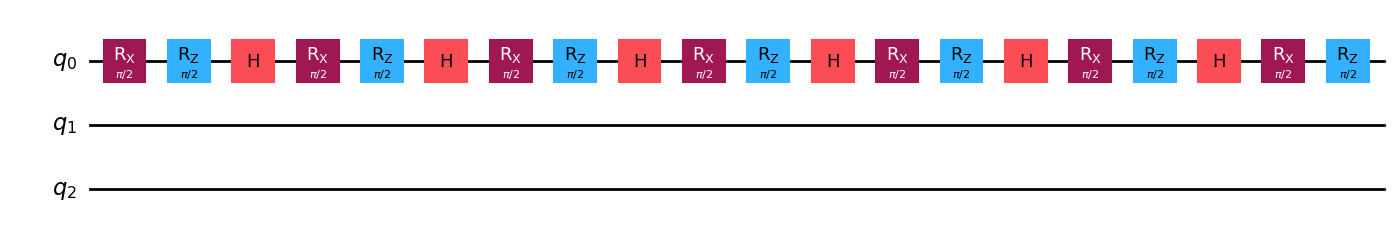

In [33]:
initial_circuit, initial_depth, initial_fidelity = eval_policy(agent, env, model_path=INITIAL_GHZ_PATH)

print(f'Initial policy depth: {initial_depth}')
print(f'Initial policy fidelity: {initial_fidelity:.4f}')
initial_circuit.draw('mpl')

Finally, our best model after training shows a circuit, equivalent to the optimal circuit for generating the GHZ state, with a depth of 3 and a fidelity of 1.0, and even using the same gates, just with slightly different qubit ordering. This indicates that the agent has successfully learned to construct an optimal quantum circuit for the target state.

Best policy depth: 3
Best policy fidelity: 1.0000


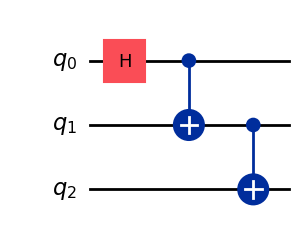

In [34]:
best_circuit, best_depth, best_fidelity = eval_policy(agent, env, model_path=BEST_GHZ_PATH)

print(f'Best policy depth: {best_depth}')
print(f'Best policy fidelity: {best_fidelity:.4f}')
best_circuit.draw('mpl')